In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# <center> Code - Engineer Internship 2019/2020 -
## <center> Flame Detection & Localization based on Temporal Approach
## <center> Part 2/2 : Different Architectures

##### Work done by : Siwar Mhadhbi

---
# <center> Importations
---

In [ ]:
import os
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use("ggplot")
%matplotlib inline

import keras

from tqdm import tqdm_notebook, tnrange
from itertools import chain
from skimage.io import imread, imshow, concatenate_images
from skimage.transform import resize
from skimage.morphology import label
from sklearn.model_selection import train_test_split

import tensorflow as tf

from keras.models import Model, load_model
from keras.layers import Input, BatchNormalization, Activation, Dense, Dropout
from keras.layers.core import Lambda, RepeatVector, Reshape
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D, GlobalMaxPool2D
from keras.layers.merge import concatenate, add
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img

from pathlib import Path
import xml.etree.ElementTree as ET
import cv2

---
# <center>  Data preparation
---


In [ ]:
# Set some parameters
im_width = 224    
im_height = 224    
border = 5

In [ ]:
def filelist(root, file_type):
    """Returns a fully-qualified list of filenames under root directory"""
    return [os.path.join(directory_path, f) for directory_path, directory_name, 
            files in os.walk(root) for f in files if f.endswith(file_type)]
            
def mysplit(s):
  head = s.rstrip('0123456789')
  tail = s[len(head):]
  return head, tail

def create_mask(bb, rows,cols):
    """Creates a mask for the bounding box of same shape as image"""
    Y = np.zeros((rows,cols))
    bb = bb.astype(np.int)
    Y[bb[0]:bb[2], bb[1]:bb[3]] = 1.
    return Y

def create_bb_array(x):
    """Generates bounding box array from a train_df row"""
    return np.array([x[1],x[0],x[3],x[2]])

In [ ]:
# ******************** Don't run Now *************************

IMG_SIZE=224

optFlow_path= '/content/drive/My Drive/EngineerInternship-Flamedetection/datasetForKaggle/OpticalFlowImages/toextract/optflow_train/train'                 ##############
anno_path= '/content/drive/My Drive/EngineerInternship-Flamedetection/datasetForKaggle/OpticalFlowImages/toextract/groundTruth_train/all annotations/annotations the rest for 1st step'              ##############

annotations = filelist(anno_path, '.xml')
data = []
classe=0
for anno_path in tqdm_notebook(annotations):
    # ***** import FLOW_IMAGE
    root = ET.parse(anno_path).getroot() 
    ch=root.find("./filename").text
    L=ch.split('.')
    ext=Path(str(optFlow_path) + '/'+mysplit(L[0])[0]+'_optflow_'+ mysplit(L[0])[1]+'.png')
    if (os.path.isfile(str(ext))):
      #print('optFlw exist : ',mysplit(L[0])[0]+'_optflow_'+ mysplit(L[0])[1]+'.png')
      img = cv2.imread(str(ext)) ###### modify the path
      img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
      img = cv2.resize(img, (im_width, im_height),3) #optical flow images are already resized anyways

      # ***** import annotations : B_BOX
      root = ET.parse(anno_path).getroot()
      exist=root.find("./object/bndbox/xmin")
      #print(exist)
      if exist is None: ######### *********************************************************************
        #print('exist is none')
        classe=0
        bb = create_bb_array([0,0,0,0])
        bb_mask_resized = cv2.resize(create_mask(bb,400,500), (im_width, im_height)) 
        bb_mask_resized = cv2.resize(bb_mask_resized, (im_width, im_height),1)
      else :
        classe=1
        x0=int(exist.text)
        y0=int(root.find("./object/bndbox/ymin").text)
        x1=int(root.find("./object/bndbox/xmax").text)
        y1=int(root.find("./object/bndbox/ymax").text)
        bb = create_bb_array([x0,y0,x1,y1])
        bb_mask_resized = cv2.resize(create_mask(bb,400,500), (im_width, im_height)) 
        bb_mask_resized = cv2.resize(bb_mask_resized, (im_width, im_height),1)

      # ***** Create Data
      data.append([img,bb_mask_resized,classe])



########    shuffle dataaa
random.shuffle(data) 
print(len(data))

In [ ]:
X=[i[0] for i in data]
#y=[i[1] for i in data]
class_true=[i[2] for i in data]

X=np.array(X).astype(np.uint32)
#y=np.array(y).astype(np.uint32)

In [ ]:
y=np.array(class_true).astype(np.uint32)

---
# <center> Preprocessing
---

In [ ]:
# Split train and valid
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.3, random_state=42)

In [ ]:
def conv2d_block(input_tensor, n_filters, kernel_size = 3, batchnorm = True):
    """Function to add 2 convolutional layers with the parameters passed to it"""
    # first layer
    x = Conv2D(filters = n_filters, kernel_size = (kernel_size, kernel_size),\
              kernel_initializer = 'he_normal', padding = 'same')(input_tensor)
    if batchnorm:
        x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    # second layer
    x = Conv2D(filters = n_filters, kernel_size = (kernel_size, kernel_size),\
              kernel_initializer = 'he_normal', padding = 'same')(x) #######################################
    if batchnorm:
        x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    return x

In [ ]:
def get_unet(input_img, n_filters = 16, dropout = 0.1, batchnorm = True):
    """Function to define the UNET Model"""
    # Contracting Path
    c1 = conv2d_block(input_img, n_filters * 1, kernel_size = 3, batchnorm = batchnorm)
    p1 = MaxPooling2D((2, 2))(c1)
    p1 = Dropout(dropout)(p1)
    
    c2 = conv2d_block(p1, n_filters * 2, kernel_size = 3, batchnorm = batchnorm)
    p2 = MaxPooling2D((2, 2))(c2)
    p2 = Dropout(dropout)(p2)
    
    c3 = conv2d_block(p2, n_filters * 4, kernel_size = 3, batchnorm = batchnorm)
    p3 = MaxPooling2D((2, 2))(c3)
    p3 = Dropout(dropout)(p3)
    
    c4 = conv2d_block(p3, n_filters * 8, kernel_size = 3, batchnorm = batchnorm)
    p4 = MaxPooling2D((2, 2))(c4)
    p4 = Dropout(dropout)(p4)
    
    c5 = conv2d_block(p4, n_filters = n_filters * 16, kernel_size = 3, batchnorm = batchnorm)
    
    # Expansive Path
    u6 = Conv2DTranspose(n_filters * 8, (3, 3), strides = (2, 2), padding = 'same')(c5)
    u6 = concatenate([u6, c4])
    u6 = Dropout(dropout)(u6)
    c6 = conv2d_block(u6, n_filters * 8, kernel_size = 3, batchnorm = batchnorm)
    
    u7 = Conv2DTranspose(n_filters * 4, (3, 3), strides = (2, 2), padding = 'same')(c6)
    u7 = concatenate([u7, c3])
    u7 = Dropout(dropout)(u7)
    c7 = conv2d_block(u7, n_filters * 4, kernel_size = 3, batchnorm = batchnorm)
    
    u8 = Conv2DTranspose(n_filters * 2, (3, 3), strides = (2, 2), padding = 'same')(c7)
    u8 = concatenate([u8, c2])
    u8 = Dropout(dropout)(u8)
    c8 = conv2d_block(u8, n_filters * 2, kernel_size = 3, batchnorm = batchnorm)
    
    u9 = Conv2DTranspose(n_filters * 1, (3, 3), strides = (2, 2), padding = 'same')(c8)
    u9 = concatenate([u9, c1])
    u9 = Dropout(dropout)(u9)
    c9 = conv2d_block(u9, n_filters * 1, kernel_size = 3, batchnorm = batchnorm)
    
    outputs = Conv2D(1, (1, 1), activation='sigmoid')(c9)
    model = Model(inputs=[input_img], outputs=[outputs])
    
    return model

In [ ]:
input_img = Input((im_height, im_width, 3), name='img')
model = get_unet(input_img, n_filters=16, dropout=0.05, batchnorm=True)
model.compile(optimizer=Adam(), loss="binary_crossentropy", metrics=["accuracy"])

In [ ]:
model.summary()

Model: "functional_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
img (InputLayer)                [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv2d_26 (Conv2D)              (None, 224, 224, 16) 448         img[0][0]                        
__________________________________________________________________________________________________
batch_normalization_24 (BatchNo (None, 224, 224, 16) 64          conv2d_26[0][0]                  
__________________________________________________________________________________________________
activation_24 (Activation)      (None, 224, 224, 16) 0           batch_normalization_24[0][0]     
_______________________________________________________________________________________

In [ ]:
callbacks = [
    EarlyStopping(patience=5, verbose=1),
    ReduceLROnPlateau(factor=0.1, patience=5, min_lr=0.00001, verbose=1),
    ModelCheckpoint('model-tgs-salt.h5', verbose=1, save_best_only=True, save_weights_only=True)
]

In [ ]:
results = model.fit(X_train, y_train, 
                    batch_size=16, epochs=50, callbacks=callbacks,   #16 ,, 5
                    validation_data=(X_valid, y_valid))

Epoch 1/50
452/452 [==============================] - ETA: 0s - loss: 0.2560 - accuracy: 0.9345
Epoch 00001: val_loss improved from inf to 0.15963, saving model to model-tgs-salt.h5
452/452 [==============================] - 46s 102ms/step - loss: 0.2560 - accuracy: 0.9345 - val_loss: 0.1596 - val_accuracy: 0.9464
Epoch 2/50
452/452 [==============================] - ETA: 0s - loss: 0.1119 - accuracy: 0.9638
Epoch 00002: val_loss improved from 0.15963 to 0.12301, saving model to model-tgs-salt.h5
452/452 [==============================] - 45s 99ms/step - loss: 0.1119 - accuracy: 0.9638 - val_loss: 0.1230 - val_accuracy: 0.9600
Epoch 3/50
452/452 [==============================] - ETA: 0s - loss: 0.0926 - accuracy: 0.9684
Epoch 00003: val_loss did not improve from 0.12301
452/452 [==============================] - 44s 98ms/step - loss: 0.0926 - accuracy: 0.9684 - val_loss: 0.1829 - val_accuracy: 0.9186
Epoch 4/50
452/452 [==============================] - ETA: 0s - loss: 0.0805 - accura

In [ ]:
# load the best model
model.load_weights('/content/model-tgs-salt.h5')

In [ ]:
preds = model.predict(X, verbose=1)
#preds = model.predict(X_valid, verbose=1)
#preds = model.predict(X, verbose=1)

preds_t=(preds > 0.5).astype(np.uint32)

323/323 [==============================] - 16s 50ms/step


In [ ]:
class_pred=[]
cnt=0
for i in range(len(preds)):
  if preds[i].max()<=0.5 :
    class_pred.append(0)
    cnt=cnt+1
  else:
    class_pred.append(1)
print (' <no fire> predected : ',cnt)


 <no fire> predected :  4470


In [ ]:
# for X
gt=class_true 

# for preds
pr=class_pred

In [ ]:
import sklearn
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import  classification_report
from sklearn.metrics import auc , roc_auc_score, roc_curve
import seaborn as sns

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


Confusion matrix:
 [[4251   73]
 [ 219 5788]]


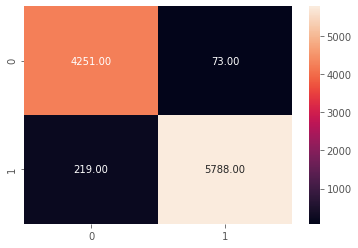

In [ ]:
#confusion matrix
c = confusion_matrix(gt,pr)
print('Confusion matrix:\n',c)
sns.heatmap(c,annot=True,fmt='0.2f')

---
# <center> Testing
---

In [ ]:
# ******************** Don't run Now *************************

IMG_SIZE=224

optFlow_path_test= '/content/drive/My Drive/EngineerInternship-Flamedetection/datasetForKaggle/OpticalFlowImages/toextract/optflow_test'           
anno_path_test= '/content/drive/My Drive/EngineerInternship-Flamedetection/datasetForKaggle/OpticalFlowImages/toextract/groundTruth_test'             

annotations = filelist(anno_path_test, '.xml')
print(annotations)
data_test = []
classe=0
for anno_path in tqdm_notebook(annotations):
    # ***** import FLOW_IMAGE
    root = ET.parse(anno_path).getroot() 
    ch=root.find("./filename").text
    L=ch.split('.')
    ext=Path(str(optFlow_path_test) + '/'+mysplit(L[0])[0]+'_optflow_'+ mysplit(L[0])[1]+'.png')
    if (os.path.isfile(str(ext))):
      img = cv2.imread(str(ext)) 
      img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
      img = cv2.resize(img, (im_width, im_height),3) 

      # ***** import annotations : B_BOX
      root = ET.parse(anno_path).getroot()
      exist=root.find("./object/bndbox/xmin")
      if exist is None: 
        classe=0
      else :
        classe=1

      # ***** Create Data
      data_test.append([img,classe])

########    shuffle dataaa
random.shuffle(data_test) 
print(len(data_test))

['/content/drive/My Drive/EngineerInternship-Flamedetection/datasetForKaggle/OpticalFlowImages/toextract/groundTruth_test/icra450.xml', '/content/drive/My Drive/EngineerInternship-Flamedetection/datasetForKaggle/OpticalFlowImages/toextract/groundTruth_test/icra387.xml', '/content/drive/My Drive/EngineerInternship-Flamedetection/datasetForKaggle/OpticalFlowImages/toextract/groundTruth_test/icra499.xml', '/content/drive/My Drive/EngineerInternship-Flamedetection/datasetForKaggle/OpticalFlowImages/toextract/groundTruth_test/icra392.xml', '/content/drive/My Drive/EngineerInternship-Flamedetection/datasetForKaggle/OpticalFlowImages/toextract/groundTruth_test/icra379.xml', '/content/drive/My Drive/EngineerInternship-Flamedetection/datasetForKaggle/OpticalFlowImages/toextract/groundTruth_test/icra478.xml', '/content/drive/My Drive/EngineerInternship-Flamedetection/datasetForKaggle/OpticalFlowImages/toextract/groundTruth_test/icra512.xml', '/content/drive/My Drive/EngineerInternship-Flamedetec

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  if sys.path[0] == '':



3605


In [ ]:
X_test=[i[0] for i in data_test]
class_true_test=[i[1] for i in data_test]

X_test=np.array(X_test).astype(np.uint32)

In [ ]:
# load the best model
model.load_weights('/content/model-tgs-salt_lowComplexity.h5')
#

In [ ]:
y_pred_test=model.predict(X_test, verbose=1)
y_pred_test_t=(y_pred_test > 0.5).astype(np.uint32)

113/113 [==============================] - 2s 16ms/step


In [ ]:
class_pred_test=[]
cnt=0
for i in range(len(y_pred_test_t)):
  if y_pred_test_t[i].max()<=0.5:
    class_pred_test.append(0)
    cnt=cnt+1
  else:
    class_pred_test.append(1)

In [ ]:
gt=class_true_test
pr=class_pred_test

Confusion matrix:
 [[ 742 1496]
 [ 244 1123]]


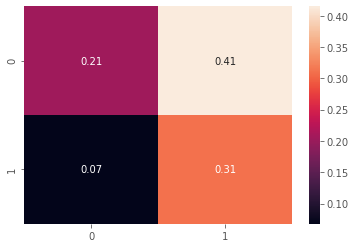

In [ ]:
#confusion matrix
c = confusion_matrix(gt,pr)
print('Confusion matrix:\n',c)
sns.heatmap(c/len(pr),annot=True,fmt='0.2f')

In [ ]:
from sklearn.metrics import accuracy_score
# accuracy: (tp + tn) / (p + n)
accuracy = accuracy_score(gt, pr)
print('Accuracy: %f' % accuracy)

# precision tp / (tp + fp)
precision = precision_score(gt,pr)
print('Precision: %f' % precision)

# recall: tp / (tp + fn)
recall = recall_score(gt,pr)
print('Recall: %f' % recall)

# f1_score : 2 tp / (2 tp + fp + fn)
f1 = f1_score(gt,pr)
print('F1 score: %f' % f1)

# ROC_AUC
print('ROC AUC score : ',roc_auc_score(gt, pr))

Accuracy: 0.517337
Precision: 0.428790
Recall: 0.821507
F1 score: 0.563472
ROC AUC score :  0.5765264863797688


---
# <center> Reduce Model Complexity : - 1 layer encoder / -1 layer decoder
---

In [ ]:
def get_unet(input_img, n_filters = 16, dropout = 0.1, batchnorm = True):
    """Function to define the UNET Model"""
    # Contracting Path
    c1 = conv2d_block(input_img, n_filters * 1, kernel_size = 3, batchnorm = batchnorm)
    p1 = MaxPooling2D((2, 2))(c1)
    p1 = Dropout(dropout)(p1)
    
    c2 = conv2d_block(p1, n_filters * 2, kernel_size = 3, batchnorm = batchnorm)
    p2 = MaxPooling2D((2, 2))(c2)
    p2 = Dropout(dropout)(p2)
    
    c3 = conv2d_block(p2, n_filters * 4, kernel_size = 3, batchnorm = batchnorm)
    p3 = MaxPooling2D((2, 2))(c3)
    p3 = Dropout(dropout)(p3)
    
    c5 = conv2d_block(p3, n_filters = n_filters * 16, kernel_size = 3, batchnorm = batchnorm)
    
    # Expansive Path
    u6 = Conv2DTranspose(n_filters * 4, (3, 3), strides = (2, 2), padding = 'same')(c5)
    u6 = concatenate([u6, c3])
    u6 = Dropout(dropout)(u6)
    c6 = conv2d_block(u6, n_filters * 4, kernel_size = 3, batchnorm = batchnorm)
    
    u7 = Conv2DTranspose(n_filters * 2, (3, 3), strides = (2, 2), padding = 'same')(c6)
    u7 = concatenate([u7, c2])
    u7 = Dropout(dropout)(u7)
    c7 = conv2d_block(u7, n_filters * 2, kernel_size = 3, batchnorm = batchnorm)
    
    u8 = Conv2DTranspose(n_filters * 1, (3, 3), strides = (2, 2), padding = 'same')(c7)
    u8 = concatenate([u8, c1])
    u8 = Dropout(dropout)(u8)
    c8 = conv2d_block(u8, n_filters * 1, kernel_size = 3, batchnorm = batchnorm)
    
    outputs = Conv2D(1, (1, 1), activation='sigmoid')(c8)
    model = Model(inputs=[input_img], outputs=[outputs])
    
    return model

In [ ]:
input_img = Input((im_height, im_width, 3), name='img')
model = get_unet(input_img, n_filters=16, dropout=0.05, batchnorm=True)
model.compile(optimizer=Adam(), loss="binary_crossentropy", metrics=["accuracy"])

In [ ]:
model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
img (InputLayer)                [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 224, 224, 16) 448         img[0][0]                        
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 224, 224, 16) 64          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 224, 224, 16) 0           batch_normalization[0][0]        
_______________________________________________________________________________________

In [ ]:
callbacks = [
    EarlyStopping(patience=10, verbose=1),
    ReduceLROnPlateau(factor=0.1, patience=5, min_lr=0.00001, verbose=1),
    ModelCheckpoint('model-tgs-salt_lowComplexity.h5', verbose=1, save_best_only=True, save_weights_only=True)
]

In [ ]:
results = model.fit(X_train, y_train, 
                    batch_size=16, epochs=50, callbacks=callbacks,   #16 ,, 5
                    validation_data=(X_valid, y_valid))

Epoch 1/50
452/452 [==============================] - ETA: 0s - loss: 0.1506 - accuracy: 0.9553
Epoch 00001: val_loss improved from inf to 0.31089, saving model to model-tgs-salt_lowComplexity.h5
452/452 [==============================] - 43s 96ms/step - loss: 0.1506 - accuracy: 0.9553 - val_loss: 0.3109 - val_accuracy: 0.9496
Epoch 2/50
452/452 [==============================] - ETA: 0s - loss: 0.1092 - accuracy: 0.9638
Epoch 00002: val_loss improved from 0.31089 to 0.22823, saving model to model-tgs-salt_lowComplexity.h5
452/452 [==============================] - 42s 94ms/step - loss: 0.1092 - accuracy: 0.9638 - val_loss: 0.2282 - val_accuracy: 0.9491
Epoch 3/50
452/452 [==============================] - ETA: 0s - loss: 0.0989 - accuracy: 0.9670
Epoch 00003: val_loss improved from 0.22823 to 0.14272, saving model to model-tgs-salt_lowComplexity.h5
452/452 [==============================] - 42s 94ms/step - loss: 0.0989 - accuracy: 0.9670 - val_loss: 0.1427 - val_accuracy: 0.9552
Epoch

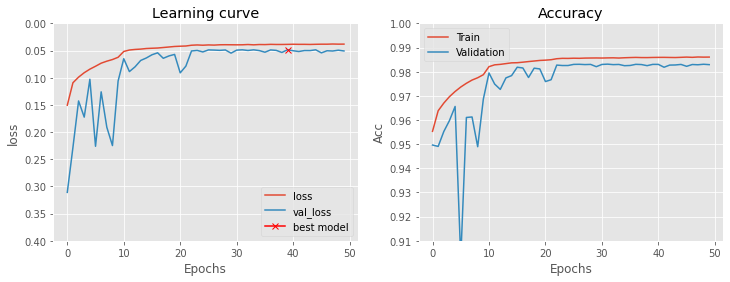

In [ ]:
plt.figure(figsize=(12,4))

plt.subplot(121)
plt.title("Learning curve")
plt.plot(results.history["loss"], label="loss")
plt.plot(results.history["val_loss"], label="val_loss")
plt.plot( np.argmin(results.history["val_loss"]), np.min(results.history["val_loss"]), marker="x", color="r", label="best model")
plt.xlabel("Epochs")
plt.ylabel("loss")
plt.legend()
plt.ylim(ymax = 0, ymin = 0.4)

plt.subplot(122)
plt.plot(results.history['accuracy'], label='Train')
plt.plot(results.history['val_accuracy'], label = 'Validation')
plt.title('Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Acc')
plt.grid(True);
plt.legend()
plt.ylim(ymax = 1, ymin = 0.91)

plt.show()

In [ ]:
# load the best model
model.load_weights('model-tgs-salt_lowComplexity.h5')

In [ ]:
y_pred_test=model.predict(X, verbose=1)
y_pred_test_t=(y_pred_test > 0.5).astype(np.uint32)

323/323 [==============================] - 16s 48ms/step


In [ ]:
class_pred_test=[]
cnt=0
for i in range(len(y_pred_test_t)):
  if y_pred_test_t[i].max()<=0.5:
    class_pred_test.append(0)
    cnt=cnt+1
  else:
    class_pred_test.append(1)

In [ ]:
gt=class_true
pr=class_pred_test

Confusion matrix:
 [[3355  969]
 [ 184 5823]]


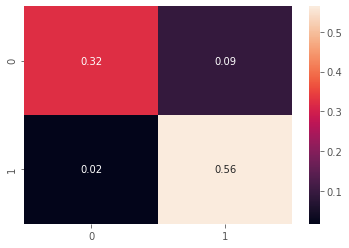

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
#confusion matrix
c = confusion_matrix(gt,pr)
print('Confusion matrix:\n',c)
sns.heatmap(c/len(pr),annot=True,fmt='0.2f')

In [ ]:
# accuracy: (tp + tn) / (p + n)
accuracy = accuracy_score(gt, pr)
print('Accuracy: %f' % accuracy)

# precision tp / (tp + fp)
precision = precision_score(gt,pr)
print('Precision: %f' % precision)

# recall: tp / (tp + fn)
recall = recall_score(gt,pr)
print('Recall: %f' % recall)

# f1_score : 2 tp / (2 tp + fp + fn)
f1 = f1_score(gt,pr)
print('F1 score: %f' % f1)

# ROC_AUC
print('ROC AUC score : ',roc_auc_score(gt, pr))

---
# <center> Reduce Model Complexity : - 2 layers encoder / -2 layers decoder
---

In [ ]:
def get_unet(input_img, n_filters = 16, dropout = 0.1, batchnorm = True):
    """Function to define the UNET Model"""
    # Contracting Path
    c1 = conv2d_block(input_img, n_filters * 1, kernel_size = 3, batchnorm = batchnorm)
    p1 = MaxPooling2D((2, 2))(c1)
    p1 = Dropout(dropout)(p1)
    
    c2 = conv2d_block(p1, n_filters * 2, kernel_size = 3, batchnorm = batchnorm)
    p2 = MaxPooling2D((2, 2))(c2)
    p2 = Dropout(dropout)(p2)
    
    c5 = conv2d_block(p2, n_filters = n_filters * 16, kernel_size = 3, batchnorm = batchnorm)
    
    # Expansive Path
    u6 = Conv2DTranspose(n_filters * 2, (3, 3), strides = (2, 2), padding = 'same')(c5)
    u6 = concatenate([u6, c2])
    u6 = Dropout(dropout)(u6)
    c6 = conv2d_block(u6, n_filters * 2, kernel_size = 3, batchnorm = batchnorm)
    
    u7 = Conv2DTranspose(n_filters * 1, (3, 3), strides = (2, 2), padding = 'same')(c6)
    u7 = concatenate([u7, c1])
    u7 = Dropout(dropout)(u7)
    c7 = conv2d_block(u7, n_filters * 1, kernel_size = 3, batchnorm = batchnorm)
    
    outputs = Conv2D(1, (1, 1), activation='sigmoid')(c7)
    model = Model(inputs=[input_img], outputs=[outputs])
    
    return model

In [ ]:
input_img = Input((im_height, im_width, 3), name='img')
model = get_unet(input_img, n_filters=16, dropout=0.05, batchnorm=True)
model.compile(optimizer=Adam(), loss="binary_crossentropy", metrics=["accuracy"])

In [ ]:
model.summary()

Model: "functional_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
img (InputLayer)                [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv2d_15 (Conv2D)              (None, 224, 224, 16) 448         img[0][0]                        
__________________________________________________________________________________________________
batch_normalization_14 (BatchNo (None, 224, 224, 16) 64          conv2d_15[0][0]                  
__________________________________________________________________________________________________
activation_14 (Activation)      (None, 224, 224, 16) 0           batch_normalization_14[0][0]     
_______________________________________________________________________________________

In [ ]:
callbacks = [
    EarlyStopping(patience=5, verbose=1),
    ReduceLROnPlateau(factor=0.1, patience=5, min_lr=0.00001, verbose=1),
    ModelCheckpoint('model-tgs-salt_low_lowComplexity.h5', verbose=1, save_best_only=True, save_weights_only=True)
]

In [ ]:
results = model.fit(X_train, y_train, 
                    batch_size=16, epochs=40, callbacks=callbacks,   #16 ,, 5
                    validation_data=(X_valid, y_valid))

Epoch 1/40
452/452 [==============================] - ETA: 0s - loss: 0.2751 - accuracy: 0.9267
Epoch 00001: val_loss improved from inf to 0.18825, saving model to model-tgs-salt_low_lowComplexity.h5
452/452 [==============================] - 44s 97ms/step - loss: 0.2751 - accuracy: 0.9267 - val_loss: 0.1882 - val_accuracy: 0.9484
Epoch 2/40
452/452 [==============================] - ETA: 0s - loss: 0.1523 - accuracy: 0.9519
Epoch 00002: val_loss did not improve from 0.18825
452/452 [==============================] - 43s 94ms/step - loss: 0.1523 - accuracy: 0.9519 - val_loss: 0.2372 - val_accuracy: 0.9490
Epoch 3/40
452/452 [==============================] - ETA: 0s - loss: 0.1359 - accuracy: 0.9564
Epoch 00003: val_loss did not improve from 0.18825
452/452 [==============================] - 43s 94ms/step - loss: 0.1359 - accuracy: 0.9564 - val_loss: 0.1977 - val_accuracy: 0.9501
Epoch 4/40
452/452 [==============================] - ETA: 0s - loss: 0.1275 - accuracy: 0.9590
Epoch 00004

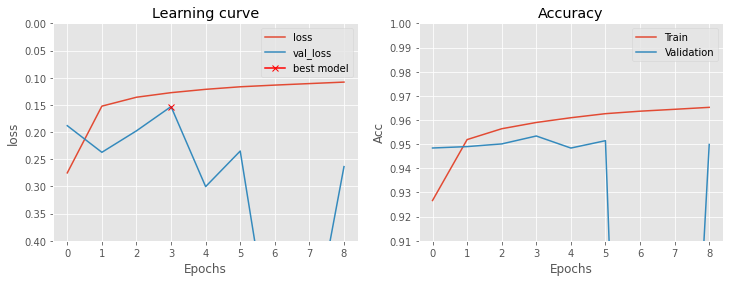

In [ ]:
plt.figure(figsize=(12,4))

plt.subplot(121)
plt.title("Learning curve")
plt.plot(results.history["loss"], label="loss")
plt.plot(results.history["val_loss"], label="val_loss")
plt.plot( np.argmin(results.history["val_loss"]), np.min(results.history["val_loss"]), marker="x", color="r", label="best model")
plt.xlabel("Epochs")
plt.ylabel("loss")
plt.legend()
plt.ylim(ymax = 0, ymin = 0.4)

plt.subplot(122)
plt.plot(results.history['accuracy'], label='Train')
plt.plot(results.history['val_accuracy'], label = 'Validation')
plt.title('Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Acc')
plt.grid(True);
plt.legend()
plt.ylim(ymax = 1, ymin = 0.91)

plt.show()

In [ ]:
# load the best model
model.load_weights('/content/model-tgs-salt_low_lowComplexity.h5')

In [ ]:
y_pred_test=model.predict(X, verbose=1)
y_pred_test_t=(y_pred_test > 0.5).astype(np.uint32)

323/323 [==============================] - 16s 50ms/step


In [ ]:
class_pred_test=[]
cnt=0
for i in range(len(y_pred_test_t)):
  if y_pred_test_t[i].max()<=0.5:
    class_pred_test.append(0)
    cnt=cnt+1
  else:
    class_pred_test.append(1)

In [ ]:
gt=class_true
pr=class_pred_test

Confusion matrix:
 [[2831 1493]
 [1208 4798]]


/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


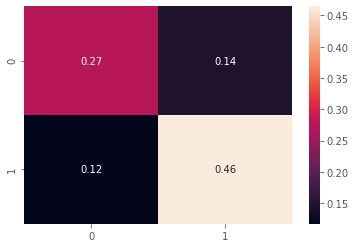

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
#confusion matrix
c = confusion_matrix(gt,pr)
print('Confusion matrix:\n',c)
sns.heatmap(c/len(pr),annot=True,fmt='0.2f')

In [ ]:
from sklearn.metrics import accuracy_score,precision_score,recall_score,f1_score,roc_auc_score
# accuracy: (tp + tn) / (p + n)
accuracy = accuracy_score(gt, pr)
print('Accuracy: %f' % accuracy)

# precision tp / (tp + fp)
precision = precision_score(gt,pr)
print('Precision: %f' % precision)

# recall: tp / (tp + fn)
recall = recall_score(gt,pr)
print('Recall: %f' % recall)

# f1_score : 2 tp / (2 tp + fp + fn)
f1 = f1_score(gt,pr)
print('F1 score: %f' % f1)

# ROC_AUC
print('ROC AUC score : ',roc_auc_score(gt, pr))

Accuracy: 0.738529
Precision: 0.762677
Recall: 0.798868
F1 score: 0.780353
ROC AUC score :  0.7267928263534185


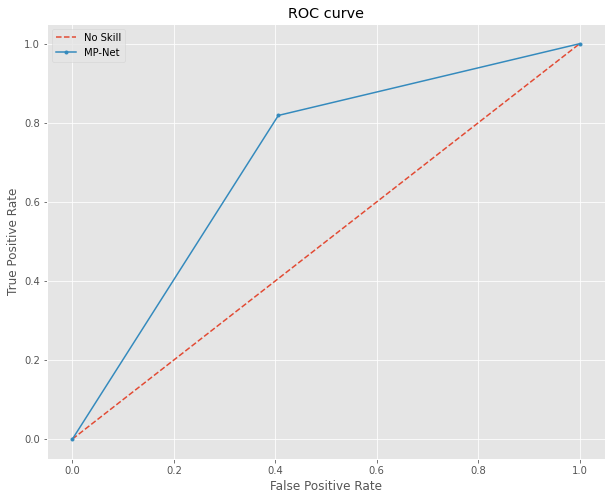

In [ ]:
from sklearn.metrics import auc , roc_auc_score, roc_curve

ns_probs = [0 for _ in range(len(pr))]

# predict probabilities
lr_probs = y_pred_test

# keep probabilities for the positive outcome only
lr_probs = lr_probs[:, 1]

# calculate roc curves
ns_fpr, ns_tpr, _ = roc_curve(gt,ns_probs)
lr_fpr, lr_tpr, _ = roc_curve(gt, pr)

# plot the roc curve for the model
plt.figure(figsize=(10,8))
plt.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill')
plt.plot(lr_fpr, lr_tpr, marker='.', label='MP-Net')
plt.legend()
plt.title('ROC curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate');

In [ ]:
y_pred=model.predict(X, verbose=1)
y_pred_t=(y_pred > 0.5).astype(np.uint32)

323/323 [==============================] - 16s 49ms/step


In [ ]:
class_pred=[]
cnt=0
for i in range(len(y_pred_t)):
  if y_pred_t[i].max()<=0.5:
    class_pred.append(0)
    cnt=cnt+1
  else:
    class_pred.append(1)

Confusion matrix:
 [[2831 1493]
 [1208 4799]]


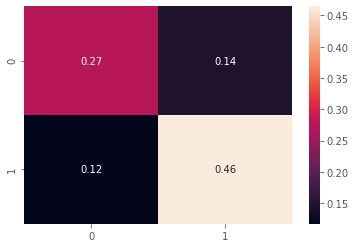

In [ ]:
gt=class_true
pr=class_pred
from sklearn.metrics import confusion_matrix
import seaborn as sns
#confusion matrix
c = confusion_matrix(gt,pr)
print('Confusion matrix:\n',c)
sns.heatmap(c/len(pr),annot=True,fmt='0.2f')

In [ ]:
from sklearn.metrics import accuracy_score,precision_score,recall_score,f1_score,roc_auc_score
# accuracy: (tp + tn) / (p + n)
accuracy = accuracy_score(gt, pr)
print('Accuracy: %f' % accuracy)

# precision tp / (tp + fp)
precision = precision_score(gt,pr)
print('Precision: %f' % precision)

# recall: tp / (tp + fn)
recall = recall_score(gt,pr)
print('Recall: %f' % recall)

# f1_score : 2 tp / (2 tp + fp + fn)
f1 = f1_score(gt,pr)
print('F1 score: %f' % f1)

# ROC_AUC
print('ROC AUC score : ',roc_auc_score(gt, pr))

Accuracy: 0.738554
Precision: 0.762715
Recall: 0.798901
F1 score: 0.780389
ROC AUC score :  0.7268095678384469


---
# <center> Model 2 _ Late fusion
---

In [ ]:
def conv2d_block(input_tensor, n_filters, kernel_size = 3, batchnorm = True):
    """Function to add 2 convolutional layers with the parameters passed to it"""
    # first layer
    x = Conv2D(filters = n_filters, kernel_size = (kernel_size, kernel_size),\
              kernel_initializer = 'he_normal', padding = 'same')(input_tensor)
    if batchnorm:
        x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    # second layer
    x = Conv2D(filters = n_filters, kernel_size = (kernel_size, kernel_size),\
              kernel_initializer = 'he_normal', padding = 'same')(x) #######################################
    if batchnorm:
        x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    return x

In [ ]:
def get_unet(input_img, n_filters = 16, dropout = 0.1, batchnorm = True):
    """Function to define the UNET Model"""
    # Contracting Path
    c1 = conv2d_block(input_img, n_filters * 1, kernel_size = 3, batchnorm = batchnorm)
    p1 = MaxPooling2D((2, 2))(c1)
    p1 = Dropout(dropout)(p1)
    
    
    c5 = conv2d_block(p1, n_filters = n_filters * 16, kernel_size = 3, batchnorm = batchnorm)
    
    # Expansive Path
    
    u7 = Conv2DTranspose(n_filters * 1, (3, 3), strides = (2, 2), padding = 'same')(c5)
    u7 = concatenate([u7, c1])
    u7 = Dropout(dropout)(u7)
    c7 = conv2d_block(u7, n_filters * 1, kernel_size = 3, batchnorm = batchnorm)
    

    p2 = MaxPooling2D((2, 2))(c7)
    p2 = Dropout(dropout)(p2)

    a=keras.layers.Flatten()(p2)
    b=keras.layers.Dense(64,activation='relu')(a)
    c=Dropout(dropout)(b)
    d=keras.layers.Dense(16,activation='relu')(c)
    e=Dropout(dropout)(d)

    outputs=keras.layers.Dense(1,activation='sigmoid')(e)

    model = Model(inputs=[input_img], outputs=[outputs])
    
    return model

In [ ]:
input_img = Input((im_height, im_width, 3), name='img')
model = get_unet(input_img, n_filters=16, dropout=0.05, batchnorm=True)
model.compile(optimizer=Adam(), loss="binary_crossentropy", metrics=["accuracy"])

In [ ]:
model.summary()

Model: "functional_13"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
img (InputLayer)                [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv2d_52 (Conv2D)              (None, 224, 224, 16) 448         img[0][0]                        
__________________________________________________________________________________________________
batch_normalization_52 (BatchNo (None, 224, 224, 16) 64          conv2d_52[0][0]                  
__________________________________________________________________________________________________
activation_52 (Activation)      (None, 224, 224, 16) 0           batch_normalization_52[0][0]     
______________________________________________________________________________________

In [ ]:
callbacks = [
    EarlyStopping(patience=5, verbose=1),
    ReduceLROnPlateau(factor=0.1, patience=5, min_lr=0.00001, verbose=1),
    ModelCheckpoint('model-tgs-salt.h5', verbose=1, save_best_only=True, save_weights_only=True)
]

In [ ]:
results = model.fit(X_train, y_train, 
                    batch_size=16, epochs=25, callbacks=callbacks,   #16 ,, 5
                    validation_data=(X_valid, y_valid))

Epoch 1/25
452/452 [==============================] - ETA: 0s - loss: 1.4476 - accuracy: 0.6587
Epoch 00001: val_loss improved from inf to 0.61060, saving model to model-tgs-salt.h5
452/452 [==============================] - 56s 123ms/step - loss: 1.4476 - accuracy: 0.6587 - val_loss: 0.6106 - val_accuracy: 0.6906
Epoch 2/25
452/452 [==============================] - ETA: 0s - loss: 0.5956 - accuracy: 0.7043
Epoch 00002: val_loss improved from 0.61060 to 0.53816, saving model to model-tgs-salt.h5
452/452 [==============================] - 56s 123ms/step - loss: 0.5956 - accuracy: 0.7043 - val_loss: 0.5382 - val_accuracy: 0.7448
Epoch 3/25
452/452 [==============================] - ETA: 0s - loss: 0.5118 - accuracy: 0.7675
Epoch 00003: val_loss improved from 0.53816 to 0.46089, saving model to model-tgs-salt.h5
452/452 [==============================] - 56s 123ms/step - loss: 0.5118 - accuracy: 0.7675 - val_loss: 0.4609 - val_accuracy: 0.8077
Epoch 4/25
452/452 [========================

In [ ]:
# load the best model
model.load_weights('/content/model-tgs-salt.h5')

---
# <center> PREDICTIONS _ test
---

In [ ]:
preds = model.predict(X_test, verbose=1)
#preds = model.predict(X_valid, verbose=1)
#preds = model.predict(X, verbose=1)

preds_t=(preds > 0.5).astype(np.uint32)

113/113 [==============================] - 7s 64ms/step


In [ ]:
class_pred=[]
cnt=0
for i in range(len(preds)):
  if preds[i].max()<=0.5 :
    class_pred.append(0)
    cnt=cnt+1
  else:
    class_pred.append(1)
print (' <no fire> predected : ',cnt)


 <no fire> predected :  1720


In [ ]:
# for X
gt=class_true_test

# for preds
pr=class_pred

Confusion matrix:
 [[1093 1145]
 [ 627  740]]


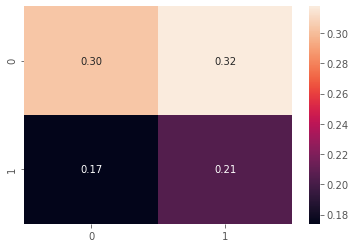

In [ ]:
#confusion matrix
c = confusion_matrix(gt,pr)
print('Confusion matrix:\n',c)
sns.heatmap(c/len(pr),annot=True,fmt='0.2f')


In [ ]:
from sklearn.metrics import accuracy_score
# accuracy: (tp + tn) / (p + n)
accuracy = accuracy_score(gt, pr)
print('Accuracy: %f' % accuracy)

# precision tp / (tp + fp)
precision = precision_score(gt,pr)
print('Precision: %f' % precision)

# recall: tp / (tp + fn)
recall = recall_score(gt,pr)
print('Recall: %f' % recall)

# f1_score : 2 tp / (2 tp + fp + fn)
f1 = f1_score(gt,pr)
print('F1 score: %f' % f1)

# ROC_AUC
print('ROC AUC score : ',roc_auc_score(gt, pr))

Accuracy: 0.508460
Precision: 0.392573
Recall: 0.541331
F1 score: 0.455105
ROC AUC score :  0.5148569334753245
